<a href="https://colab.research.google.com/github/Dopamine-Max/CNN-Milestone-projects/blob/main/Pyschometric_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #4 CNN MILESTONE PROJECT
##Performing a Pyschometric Test for Horizontal/Vertical Line Distinctions
####Builiding a CNN that firstly trains on 30x30 generated vertical/horizontal lines on random gaussian noise, then classifies brand new images of slopes ranging from -30 to 30 on if they are vertical/horizontal.


In [105]:
# import libraries

import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-105-a561a675aacf>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [106]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [107]:
# create Lines with Gaussian Noise

nImages = 2500
imgSize = 30

#initialize tensor containing images
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)

for i in range(nImages):

  #and add noise
  G  = np.random.randn(imgSize,imgSize)

  #add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1 # horizontal
  else:
    G[:,i1:i1+i2] = 1 # vertical
    labels[i] = 1

  #add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

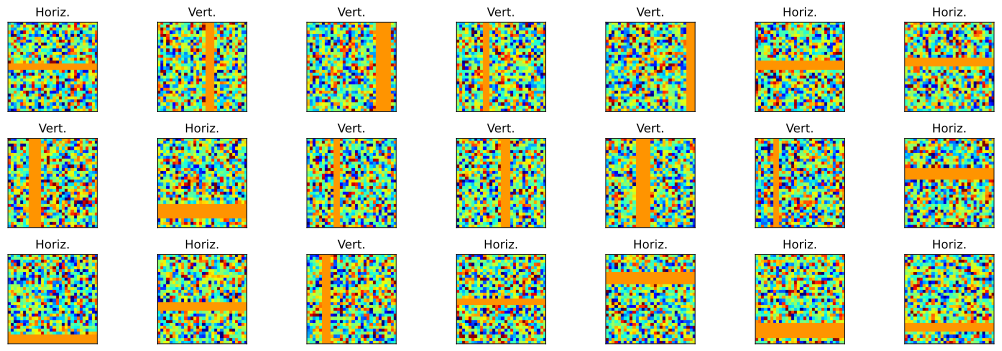

In [108]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-2,vmax=2,cmap='jet',extent=[-4,4,-4,4],origin='upper')

  title = 'Horiz.' if labels[whichpic].item()==0 else 'Vert.'
  ax.set_title(title)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [109]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 20
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [110]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(

          # conv/pool block 1
          nn.Conv2d(1,4,3,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),

          # conv/pool block 2
          nn.Conv2d(4,8,3,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),

          # linear decision layer
          nn.Flatten(),
          nn.Linear(7*7*8,1)
      )

    def forward(self,x):
      return self.enc(x)

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [111]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# confirm shapes of prediction and actual
print(' ')
print(yHat.shape)
print(y.shape)

# finally, make sure the loss is computed
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([20, 1])
torch.Size([20, 1])
 
Loss:
tensor(0.7069, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [112]:
# count the total number of parameters in the model
net.to(device)
summary(net,(1,30,30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]              40
              ReLU-2            [-1, 4, 30, 30]               0
         AvgPool2d-3            [-1, 4, 15, 15]               0
            Conv2d-4            [-1, 8, 15, 15]             296
              ReLU-5            [-1, 8, 15, 15]               0
         AvgPool2d-6              [-1, 8, 7, 7]               0
           Flatten-7                  [-1, 392]               0
            Linear-8                    [-1, 1]             393
Total params: 729
Trainable params: 729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.00
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [113]:
# a function that trains the model

def traingaussNet():

  # number of epochs
  epochs = 5

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  losses = torch.zeros(epochs)
  trainAcc = torch.zeros(epochs)
  testAcc = torch.zeros(epochs)


  # loop over epochs
  for epochi in range(epochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      #push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      #compute accuracy
      batchAcc.append(100*(torch.mean(((yHat>0).float().detach() == y).float())).item())
    # end of batch loop...

    #average training accuracy across batches
    trainAcc[epochi] = np.mean(batchAcc)
    #average loss across batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    #compute accuracy from this batch
    testAcc[epochi] = 100*(torch.mean(((yHat>0).float().detach() == y).float())).item()

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [114]:
# train the model
trainAcc,testAcc,losses,net = traingaussNet()

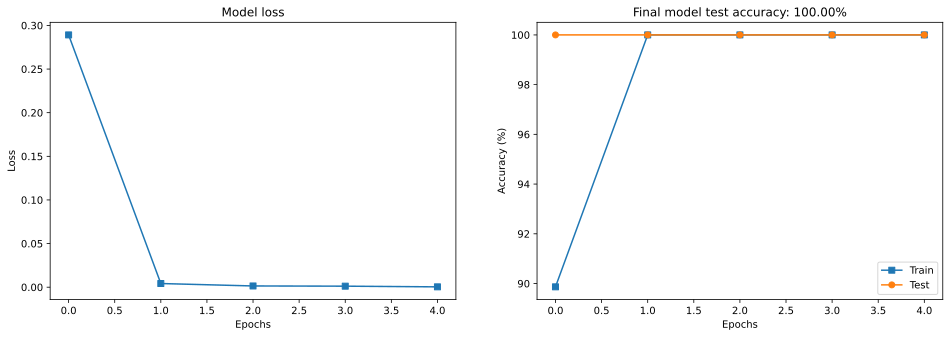

In [115]:
# plot the loss and accuracy of the model on the gaussian lines
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

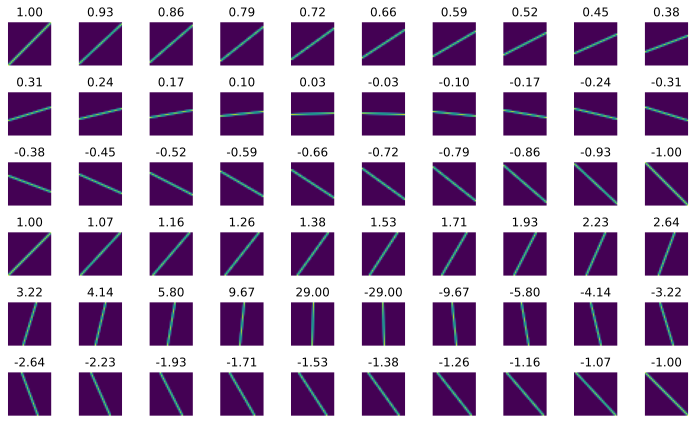

In [116]:
### now for the "true" test
# create lines in images

from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  # create lines with |slope|<1
  #point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  #create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  # create lines with |slope|>1
  #point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  #create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  #plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

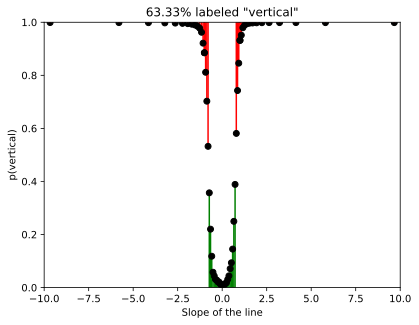

In [117]:
# run the images through the model

#randomly shuffle the images, just to be on the safe side and also convert to tensor
ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))


#now generate the prediction (horizontal or vertical)
net.eval()
yHat = torch.sigmoid( net(imgT) ).detach()

#plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  if yHat[i]>.5:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[1,yHat[i]],'r')
  else:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[0,yHat[i]],'g')

plt.plot(slopes[ridx],yHat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title(f'{torch.mean(100*(yHat>.5).float()).item():.2f}% labeled "vertical"')
plt.ylim([0,1])
plt.xlim([-10,10]) # this actually clips two data points
plt.show()

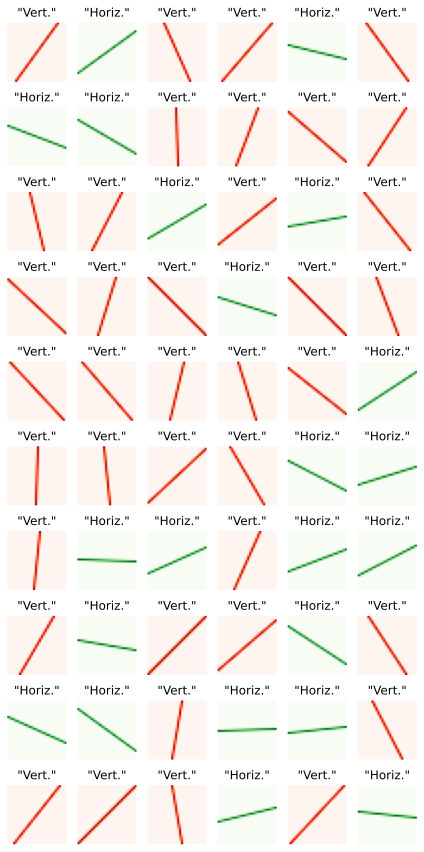

In [118]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):

  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')

  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()